In [72]:
import psycopg2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 5)

In [73]:
from getpass import getpass
MIMIC_PW = getpass('mimic password?')

mimic password?········


In [74]:
conn = psycopg2.connect(database='mimic', 
        user='mimic', password=MIMIC_PW,
        host='grinder.inf.ethz.ch', port=5432)
cur = conn.cursor()

# 1. Admission inspections

## admission type stat

In [75]:
cur.execute('''
select admission_type, count(*) as cnt
from admissions
group by admission_type;''')
print cur.fetchall()

[('ELECTIVE', 7706L), ('URGENT', 1336L), ('NEWBORN', 7863L), ('EMERGENCY', 42071L)]


In [76]:
cur.execute('''
select count( *) from admissions 
where deathtime is not null;''')
print cur.fetchall()

[(5854L,)]


In [77]:
cur.execute('''
select count( *) from admissions 
where deathtime is null;''')
print cur.fetchall()

[(53122L,)]


## stay duration stat

In [78]:
cur.execute('''
select dischtime-admittime as duration
from admissions
order by duration;''')

In [79]:
dur = cur.fetchall()

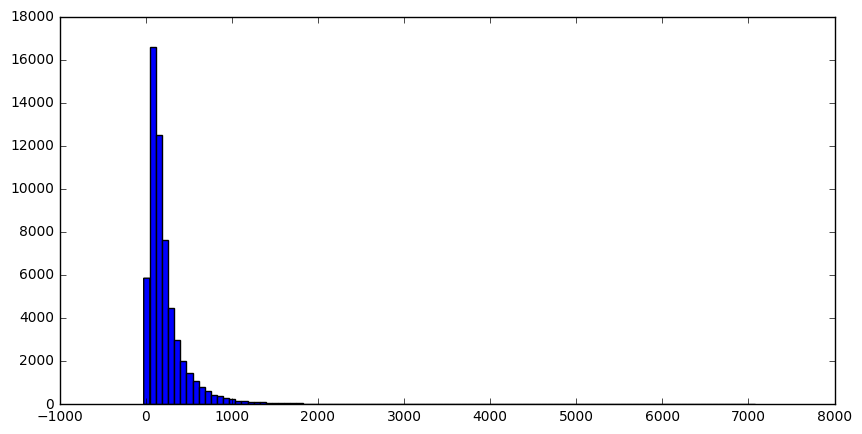

In [80]:
durr = map(lambda x: x[0].total_seconds()/3600, dur)
h = plt.hist(durr, bins=100)

## diagnosis length(in chars) stat

In [81]:
cur.execute('''
select char_length(diagnosis) as len 
from admissions
order by len desc;''')

In [82]:
dia = cur.fetchall()

In [83]:
len(dia)

58976

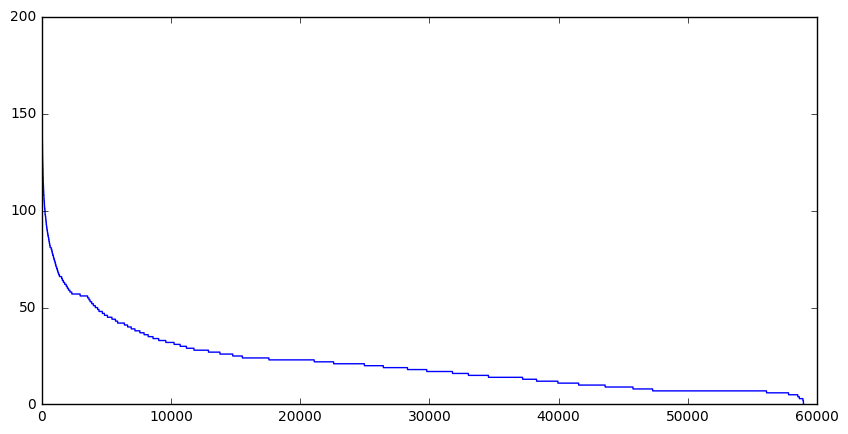

In [84]:
plt.plot(dia)

## JOIN procedures_icd and noteevents

** We first do a JOIN of table procedures_icd and noteevents on subject_id **, only keep icd/notes for subject_ids that appear in both tables

**TODO: also join by `hadm_id` ? (unique to a patient's hospital stay)**

In [85]:
cur.execute('''
select distinct subject_id                                
into temp sid_note from noteevents;''')

cur.execute('''
select distinct subject_id                                
into temp sid_icd from procedures_icd;''')

cur.execute('''
select sid_icd.subject_id as subject_id 
into temp sid_join 
from sid_icd inner join sid_note
on sid_note.subject_id = sid_icd.subject_id;''')

In [86]:
cur.execute('''
select procedures_icd.* 
into temp t_proc_icd
from procedures_icd inner join sid_join 
on sid_join.subject_id = procedures_icd.subject_id;''')

# maybe I should not create large temp tables ??
cur.execute('''
select noteevents.* 
into temp t_notes
from noteevents inner join sid_join 
on sid_join.subject_id = noteevents.subject_id;''')

**from now on, work with table `t_proc_icd` and `t_notes` **

---

# 2. Procedures_icd insepction & collection

## procedures_icd  stat

In [87]:
cur.execute('''
select count(*)
from t_proc_icd;''')
NB_PROC = cur.fetchone()[0]


cur.execute('''
select count(distinct icd9_code)
from t_proc_icd;''')
NB_UNIQUE_ICD = cur.fetchone()[0]

cur.execute('''
select count(distinct subject_id)
from t_proc_icd;''')
NB_UNIQUE_SUBJECT = cur.fetchone()[0]

print '%d unique patients, %d procedures, %d unique icd codes' % \
        (NB_UNIQUE_SUBJECT, NB_PROC, NB_UNIQUE_ICD)

41886 unique patients, 238742 procedures, 2032 unique icd codes


**ICD distribution**

In [88]:
cur.execute('''
select icd9_code, count(*) as cnt
from t_proc_icd
group by icd9_code order by cnt desc;''')
icds = cur.fetchall()
icd_code, cnt = zip(*icds)

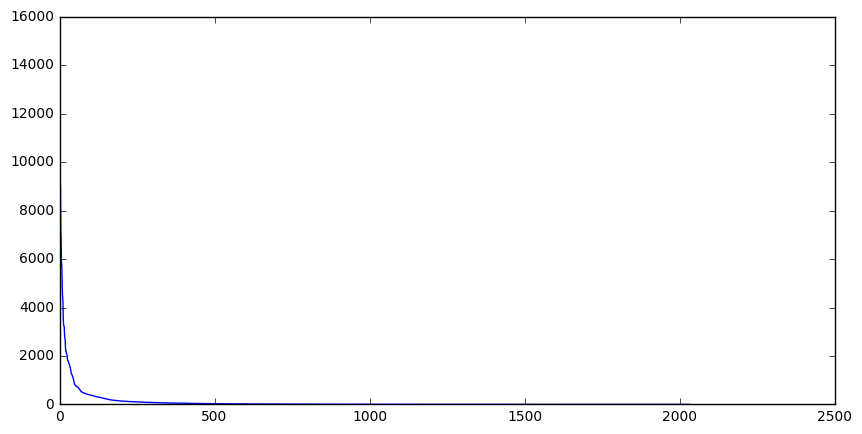

In [89]:
plt.plot(cnt)

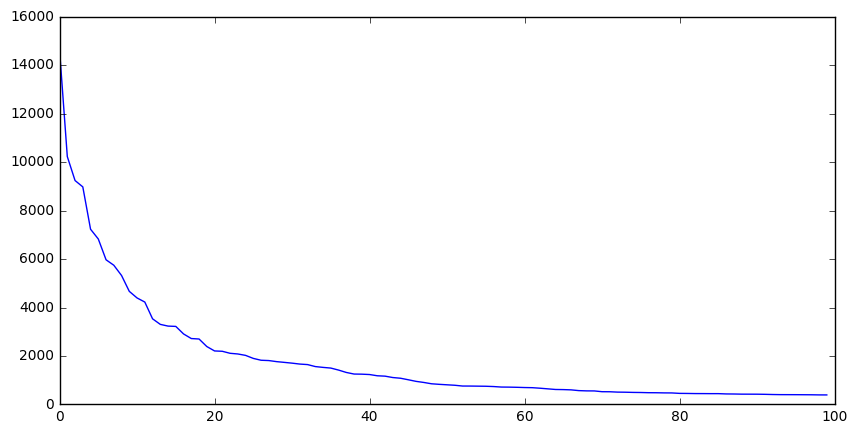

In [90]:
plt.plot(cnt[:100])

**How many icd code a patient has?**

In [91]:
cur.execute('''
select subject_id, count(*) as cnt
from t_proc_icd
group by subject_id order by cnt desc;''')
cnts = cur.fetchall()
sid, cnt = zip(*cnts)

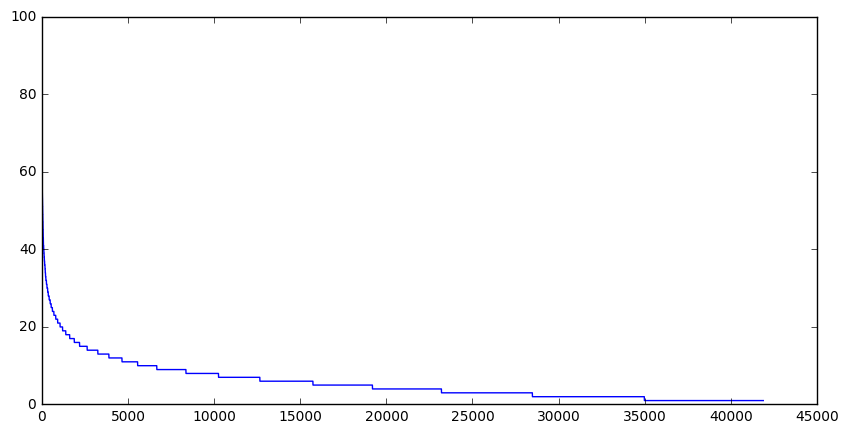

In [92]:
plt.plot(cnt)

## Collect the icd codes

In [93]:
cur.execute('''
select subject_id, string_agg(icd9_code, ' ') as icds 
from t_proc_icd 
group by subject_id
order by subject_id;''')

In [94]:
with open('subject_icds.txt','w') as f:
    for sid, icds in tqdm(cur):
        f.write( str(sid)+' '+icds + '\n')

41886it [00:00, 1121089.79it/s]


---

# 3. Noteevents inspection & collection

## eventnote stat

In [95]:
cur.execute('''
select text 
from t_notes 
limit 2;''')
for note in cur:
    print note[0] # have a look at the note text
    print '======[[[[[[======]]]]]]======' # use this as notes seperator... 

Sinus rhythm. Left axis deviation. Low limb lead voltage. Leads I and III are
uninterpretable due to artifact. No [** Location **]us tracing available for comparison.


======[[[[[[======]]]]]]======
Admission Date:  [**2769-1-24**]       Discharge Date:  [**2769-2-4**]


Service:  CT SURGERY

HISTORY OF PRESENT ILLNESS:   Mr. [**Known patient lastname 10906**] is an 82-year-old
male with a past medical history for benign prostatic
hypertrophy, hypertension, hypercholesterolemia, with recent
onset of dyspnea on exertion but denied any evidence of chest
pain.  This brought him to be evaluated by his primary care
physician, [**Name10 (NameIs) **] ultimately led to a positive stress test
showing 2 mm ST segment depressions in the inferior and
lateral leads, relieved by rest but ultimately asymptomatic.
He was admitted on [**2769-1-24**] to [**Hospital1 **] [**Hospital1 1814**] and was
therefore transferred to [**Hospital1 1499**], where he underwent cardiac catheterization.  Cardiac
cathe

In [96]:
cur.execute('''
select count(*)
from t_notes''')
NB_EVENTNOTES = cur.fetchone()[0]

cur.execute('''
select count(distinct subject_id)
from t_notes;
''')
NB_SUBJECTS = cur.fetchone()[0] # number of unique subjects(patients)

print '%d uniques subjects, %d notes in total' % (NB_SUBJECTS, NB_EVENTNOTES)

41886 uniques subjects, 2015333 notes in total


**how many notes a patient has?**

In [97]:
cur.execute('''
select count(*), subject_id
from t_notes
group by subject_id;''')
notecnt = cur.fetchall()

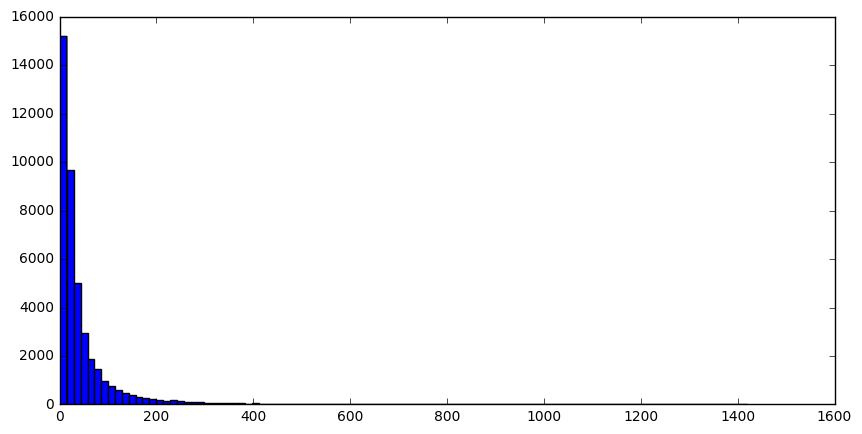

In [98]:
cnt = [ x[0] for x in notecnt]
h = plt.hist(cnt, bins=100)

In [99]:
max(notecnt, key = lambda x: x[0])

(1419L, 55672)

**There exists a person that has 1419 notes?? **

In [100]:
cur.execute('''
select * 
from t_notes
where subject_id = 55672''') # have a look at patient 55672

In [101]:
# print cur.fetchmany(10)

**Also the `charttime` field is strange: year=2097?**

    mimic=> select subject_id, row_id, charttime
    from noteevents
    order by charttime
    limit 2;
     subject_id | row_id  |      charttime      
    ------------+---------+---------------------
           6576 | 1288509 | 2097-12-07 12:55:00
           6576 | 1288510 | 2097-12-07 14:49:00
    (2 rows)


## Collect the notes

**NB**: each file `_subject_id.csv` contains informations of the patient of corresponding subject_id. 

In [104]:
import os
import pandas as pd
DATA_DIR = '/local/XW/DATA/MIMIC/noteevents_by_sid/'
!rm $DATA_DIR/*

In [105]:
CSV_HEADER = 'subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text'

cur.execute('''
select %s
from t_notes
order by subject_id,hadm_id
;''' % CSV_HEADER)  # limit 10

_current_sid = -1
_buffer = []


def write_note_to_csv(fname, diry=DATA_DIR, header=CSV_HEADER.split(',')):
    if len(_buffer)==0: return
    fname = os.path.join(diry,fname)
    df = pd.DataFrame(_buffer, columns=header)
    df.to_csv(fname, index=False, header=True)
#     print fname

for line in tqdm(cur, total=NB_EVENTNOTES):
    sid = line[0]
    if sid != _current_sid:
        write_note_to_csv("%d.csv" % _current_sid)
        _current_sid = sid
        _buffer = []    
    _buffer.append(line)

write_note_to_csv("%d.csv" % _current_sid)

2015333it [02:04, 16234.77it/s]


---

In [106]:
cur.close()
conn.close()